# Semantic change in LatinISE (terms related to revolution)


Barbara McGillivray, Paola Marongiu

This notebook contains the code used for the word embedding analysis of the terms related to revolution for the use case 4.2.1 of the working group 4 of the COST Action “Nexus Linguarum” (CA 18209). 

## Initialisation

I install version 4.0 of gensim, which is needed to train the word2vec models.

In [1]:
!pip install gensim==4.0
!pip install plotly

Import libraries

In [2]:
import os 
#from bs4 import BeautifulSoup
import csv
import numpy as np
import pandas as pd
#from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
#from nltk.corpus import stopwords
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from gensim.models import FastText
import gensim
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
import spacy
import plotly.express as px
import re
from statistics import mean
#from langdetect import detect
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline 

/home/paola_user/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


ModuleNotFoundError: No module named 'spacy'

# Parameters

I set the parameters of the analysis.

In [3]:
lemmas_or_tokens = "lemmas" # this can be "lemmas" or "tokens"

## Reading the files

I define the name of the folders:

In [4]:
dir_in = os.path.join("/home", "paola_user", "Scaricati", "LatinISE")
#dir_in = os.path.join("/Users", "barbaramcgillivray", "Library", "CloudStorage", "OneDrive-King'sCollegeLondon", "Research", "2022", "Nexus Linguarum WG4 UC4.2", "LatinISE")
dir_out = os.path.join(dir_in, "semantic_change_output_nexus")

I define the list of all files:

In [5]:
files = os.listdir(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens))

How many files are in the folder?


In [6]:
len(files)

1268

We only want IntraText files: (why? because some texts are repeated. add medical texts not in IntraText)

In [7]:
files = [f for f in files[:] if "IT" in f]
len(files)

670

I read the metadata file:

In [8]:
metadata_df = pd.read_csv(os.path.join(dir_in, 'latinise_metadata.csv'), sep = ",")
metadata_df = metadata_df[metadata_df['id'].str.startswith("IT")] #we want all the files from IT (one medical text is not among IntraText)
#metadata_df = metadata_df[metadata_df['date'] < 1000] #stop at x year
metadata_df

,id,title,creator,date,type,file,medical text
18,IT-LAT0001,Vulgata,Hieronymus,382,poetry,lat_0382_IT-LAT0001.txt,0
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9,poetry,lat_-009_IT-LAT0537.txt,0
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524,prose,lat_0524_IT-LAT0011.txt,0
21,IT-LAT0012,In psalmis Davidis expositio,Thomas Aquinas: Sanctus,1254,prose,lat_1254_IT-LAT0012.txt,0
22,IT-LAT0014,Adoro te devote,Thomas Aquinas: Sanctus,1254,poetry,lat_1254_IT-LAT0014.txt,0
...,...,...,...,...,...,...,...
685,IT-LAT0534_3,Dialogus de oratoribus,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_3.txt,0
686,IT-LAT0534_4,Historiae,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_4.txt,0
837,IT-MQDQ-247,medicamina faciei,"Ovidius Naso, Publius",30,poetry,lat_+0030_MQDQ-247.txt,1
1221,IT-MQDQ-440,liber medicinalis,unknown,350,poetry,lat_0350.0_MQDQ-440.txt,1


In [9]:
metadata_df.shape

(672, 7)

In [10]:
metadata_df.columns

Index(['id', 'title', 'creator', 'date', 'type', 'file', 'medical text'], dtype='object')

In [11]:
metadata_df['date'].describe

<bound method NDFrame.describe of 18       382
19        -9
20       524
21      1254
22      1254
        ... 
685      116
686      116
837       30
1221     350
1265     533
Name: date, Length: 672, dtype: int64>

In [12]:
metadata_df.dtypes

id              object
title           object
creator         object
date             int64
type            object
file            object
medical text     int64
dtype: object

Convert date to integer

In [13]:
metadata_df['date'] = metadata_df['date'].astype(int)
metadata_df.dtypes

id              object
title           object
creator         object
date             int64
type            object
file            object
medical text     int64
dtype: object

In [14]:
metadata_df.head

<bound method NDFrame.head of                 id                         title  \
18      IT-LAT0001                       Vulgata   
19      IT-LAT0537                  Ars amatoria   
20      IT-LAT0011           S. Benedicti Regula   
21      IT-LAT0012  In psalmis Davidis expositio   
22      IT-LAT0014               Adoro te devote   
...            ...                           ...   
685   IT-LAT0534_3        Dialogus de oratoribus   
686   IT-LAT0534_4                     Historiae   
837    IT-MQDQ-247             medicamina faciei   
1221   IT-MQDQ-440             liber medicinalis   
1265    IT-LAT0202                 Institutiones   

                                                creator  date    type  \
18                                           Hieronymus   382  poetry   
19                                Ovidius Naso, Publius    -9  poetry   
20                                 Benedictus Nursianus   524   prose   
21                              Thomas Aquinas: Sanct

Number of works per year:

In [15]:
metadata_df0 = metadata_df.groupby(['date']).count()
metadata_df0 = metadata_df0['id']
metadata_df0

date
-450     1
-229     1
-199     3
-185     1
-149     2
        ..
 2001    4
 2002    2
 2003    1
 2004    1
 2005    1
Name: id, Length: 263, dtype: int64

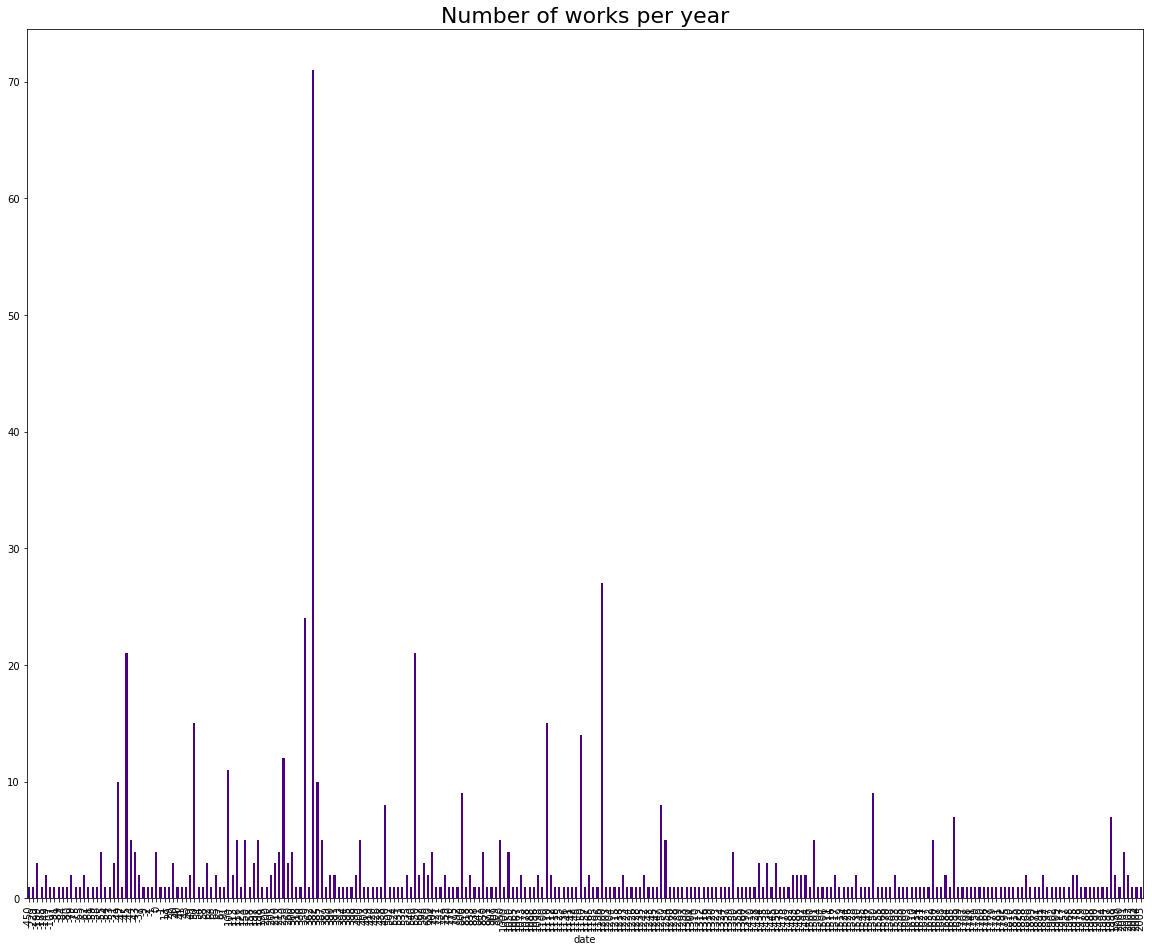

In [16]:
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per year", fontsize=22)
plt.show()

## Training embeddings for the whole corpus

Function for printing the vocabulary of a model

In [17]:
def print_vocab(model, top_n = None):
  if model == '':
    print("Empty model!")
  else:
    count = 0
    if top_n is not None:
      for index, word in enumerate(model.wv.index_to_key):
        count+= 1
        if count < top_n:
          print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
    else:
      for index, word in enumerate(model.wv.index_to_key):
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

Function that converts dates into the standard format:

In [18]:
def convert_dates(sign, date0):

    if sign == "0":
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = "+" + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = "+" + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = "+" + str(date0)
            #print("3-final_date", final_date)
    else:
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = str(sign) + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = str(sign) + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = str(sign) + str(date0)
            #print("3-final_date", final_date)

    if final_date.startswith("+"):
        final_date = final_date.replace("+", "")
    return final_date

#### Stopwords exclusion and further filtering


I exclude punctuation marks:

In [19]:
punctuation = ['.', ',', '...', ';', ':', '?']

I create a list of lists, containing the tokens of each sentence in the whole corpus:

In [20]:
corpus = list()
files_corpus = metadata_df
for index, df_line in files_corpus.iterrows():
    #print("line:",df_line['id'], df_line['time_interval'])
    sign = "+"
    #print(df_line['date'])
    if df_line['date'] < 0:
        sign = "-"
    #print("date:", convert_dates(sign, abs(df_line['date'])))
    file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
    print(file_name)
    file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
    sentences_this_file = list()
    while True:
        line = file.readline().strip()
        if line != "":
            #sentences_this_file.append(line.split(" "))
            #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
            corpus.append([token for token in line.split(" ") if token not in punctuation])
        # if line is empty end of file is reached
        if not line:
            break
    file.close()
corpus.append(sentences_this_file)

lat_0382_IT-LAT0001.txt
lat_-009_IT-LAT0537.txt
lat_0524_IT-LAT0011.txt
lat_1254_IT-LAT0012.txt
lat_1254_IT-LAT0014.txt
lat_0399_IT-LAT0015.txt
lat_0391_IT-LAT0016.txt
lat_1224_IT-LAT0017.txt
lat_1150_IT-LAT0018.txt
lat_2000_IT-LAT0021.txt
lat_1517_IT-LAT0022.txt
lat_1547_IT-LAT0023.txt
lat_1530_IT-LAT0024.txt
lat_1260_IT-LAT0025.txt
lat_1250_IT-LAT0026.txt
lat_1998_IT-LAT0027.txt
lat_-0049_IT-LAT0029.txt
lat_2001_IT-LAT0030.txt
lat_1992_IT-LAT0031.txt
lat_0158_IT-LAT0043.txt
lat_0049_IT-LAT0045.txt
lat_-0045_IT-LAT0047.txt
lat_0050_IT-LAT0051.txt
lat_0121_IT-LAT0054.txt
lat_-0049_IT-LAT0056.txt
lat_0199_IT-LAT0058.txt
lat_0387_IT-LAT0061.txt
lat_0197_IT-LAT0062.txt
lat_0050_IT-LAT0563.txt
lat_0062_IT-LAT0071.txt
lat_0049_IT-LAT0072.txt
lat_0063_IT-LAT0073.txt
lat_0000_IT-LAT0075.txt
lat_0062_IT-LAT0078.txt
lat_0058_IT-LAT0079.txt
lat_0385_IT-LAT0574.txt
lat_0040_IT-LAT0083.txt
lat_0385_IT-LAT0574_1.txt
lat_0385_IT-LAT0574_2.txt
lat_-0080_IT-LAT0093.txt
lat_-0079_IT-LAT0094.txt
lat_-00

lat_1150_IT-LAT0616.txt
lat_0950_IT-LAT0617.txt
lat_1250_IT-LAT0618.txt
lat_1088_IT-LAT0619.txt
lat_1492_IT-LAT0620.txt
lat_0250_IT-LAT0621.txt
lat_1150_IT-LAT0622.txt
lat_1150_IT-LAT0623.txt
lat_1667_IT-LAT0624.txt
lat_1695_IT-LAT0625.txt
lat_1695_IT-LAT0626.txt
lat_1695_IT-LAT0627.txt
lat_1695_IT-LAT0628.txt
lat_1695_IT-LAT0629.txt
lat_1695_IT-LAT0630.txt
lat_1695_IT-LAT0631.txt
lat_0050_IT-LAT0632.txt
lat_1243_IT-LAT0633.txt
lat_1650_IT-LAT0634.txt
lat_1245_IT-LAT0635.txt
lat_1650_IT-LAT0636.txt
lat_1550_IT-LAT0637.txt
lat_1483_IT-LAT0638.txt
lat_1627_IT-LAT0639.txt
lat_1550_IT-LAT0640.txt
lat_1988_IT-LAT0641.txt
lat_1999_IT-LAT0642.txt
lat_1450_IT-LAT0643.txt
lat_1450_IT-LAT0644.txt
lat_1650_IT-LAT0645.txt
lat_1494_IT-LAT0646.txt
lat_1350_IT-LAT0649.txt
lat_1350_IT-LAT0650.txt
lat_1650_IT-LAT0652.txt
lat_1593_IT-LAT0653.txt
lat_1593_IT-LAT0654.txt
lat_0382_IT-LAT0001_24.txt
lat_0382_IT-LAT0001_25.txt
lat_0382_IT-LAT0001_26.txt
lat_0382_IT-LAT0001_27.txt
lat_0382_IT-LAT0001_28.txt
l

FileNotFoundError: [Errno 2] No such file or directory: '/home/paola_user/Scaricati/LatinISE/preprocessed_lemmas/lat_0030_IT-MQDQ-247.txt'

In [21]:
metadata_df

,id,title,creator,date,type,file,medical text
18,IT-LAT0001,Vulgata,Hieronymus,382,poetry,lat_0382_IT-LAT0001.txt,0
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9,poetry,lat_-009_IT-LAT0537.txt,0
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524,prose,lat_0524_IT-LAT0011.txt,0
21,IT-LAT0012,In psalmis Davidis expositio,Thomas Aquinas: Sanctus,1254,prose,lat_1254_IT-LAT0012.txt,0
22,IT-LAT0014,Adoro te devote,Thomas Aquinas: Sanctus,1254,poetry,lat_1254_IT-LAT0014.txt,0
...,...,...,...,...,...,...,...
685,IT-LAT0534_3,Dialogus de oratoribus,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_3.txt,0
686,IT-LAT0534_4,Historiae,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_4.txt,0
837,IT-MQDQ-247,medicamina faciei,"Ovidius Naso, Publius",30,poetry,lat_+0030_MQDQ-247.txt,1
1221,IT-MQDQ-440,liber medicinalis,unknown,350,poetry,lat_0350.0_MQDQ-440.txt,1


In [22]:
corpus

[['in', 'principium', 'creo', 'deus', 'caelum', 'et', 'terra'],
 ['terra',
  'autem',
  'sum',
  'inanis',
  'et',
  'vacuus',
  'et',
  'tenebrae',
  'super',
  'facies',
  'abyssus',
  'et',
  'spiritus',
  'deus',
  'fero',
  'super',
  'aqua'],
 ['dico', 'deus', 'fio', 'lux', 'et', 'facio', 'sum', 'lux'],
 ['et',
  'video',
  'deus',
  'lux',
  'quod',
  'sum',
  'bonus',
  'et',
  'divisor',
  'lux',
  'atque',
  'tenebrae'],
 ['appello',
  'lux',
  'dies',
  'et',
  'tenebrae',
  'nox',
  'factumque',
  'sum',
  'vesper',
  'et',
  'mane',
  'dies',
  'unus'],
 ['dico#2',
  'quoque',
  'deus',
  'fio',
  'firmamentum',
  'in',
  'medius',
  'aqua',
  'et',
  'divido',
  'aqua',
  'ab',
  'aqua'],
 ['et',
  'facio',
  'deus',
  'firmamentum',
  'divisitque',
  'aqua',
  'quis#2',
  'sum',
  'sub',
  'firmamentum',
  'ab',
  'hic',
  'quis#2',
  'sum',
  'super',
  'firmamentum',
  'et',
  'facio',
  'sum',
  'ita'],
 ['voco',
  'deus',
  'firmamentum',
  'caelum',
  'et',
  'facio

In [23]:
len(corpus)

510552

## Test with "revolutio" on the whole corpus 

Find the word "revolutio" in the corpus (twice in LAT0820 and once in LAT0970):

In [24]:
count_sentence = 0
for sentence in corpus:
    count_sentence = count_sentence + 1
    #if count_sentence % 1000 == 0:
    #    print(count_sentence)
    for w in sentence:
        #print(w)
        if w == "revolutio" or w == "reuolutio":
            print("revolutio!!!!!")
            print(sentence)

revolutio!!!!!
['de', 'cyclus', 'decennovennali', 'aureus', 'numerus', 'C', 'yclus', 'decennovennalis', 'aureus', 'numerus', 'sum', 'revolutio', 'numerus', 'annus', 'ab', 'usque', 'ad', 'qui', 'revolutione', 'perago', 'iterum', 'ad', 'unitas', 'reditur']
revolutio!!!!!
['de', 'indictio', 'eo', 'ndictio', 'sum', 'revolutio', 'annus', 'ab', 'usque', 'ad', 'qui', 'revolutione', 'perago', 'iterum', 'reditur', 'ad', 'unitas', 'initiumque', 'sumo', 'quilibet', 'annus', 'hic', 'cyclus', 'ab', 'Januarius', 'in', 'bulla', 'pontifex']
revolutio!!!!!
['quod', 'cum', 'parum', 'reperisset', 'iterum', 'ad', 'monumentum', 'orior', 'iam', 'sol', 'cum', 'alius', 'venio', 'et', 'tunc', 'reuolutio', 'lapis', 'facio', 'sum', 'quamvis', 'Ioannes', 'hic', 'reuolutionem', 'quasi', 'prius', 'facio', 'per', 'anticipationem', 'dico#2', 'ab', 'Maria', 'uisam', 'sum']


We correct and harmonize the lemmatisation for "revolutio":

In [41]:
print(len(corpus))
count_sentence = 0
corpus_corrected = []
for sentence in corpus:
    count_sentence += 1
    if count_sentence % 1000 == 0:
        print(count_sentence)
    sentence_new = []
    for w in sentence:
        #print(w)
        if w == "revolutio" or w == "reuolutio" or w == "revolutione" or w == "reuolutionem" or w.startswith('revolutio') or w.startswith('reuolutio'):
            w = "revolutio"
        sentence_new.append(w)
    corpus_corrected.append([w for w in sentence_new])
print(len(corpus_corrected))
print(len(sentence_new))

510552
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
15

Check that the lemmatisations of "revolutio" are correct now:

In [47]:
count_sentence = 0
revolutio_sentences = []
count_revolutio_sentences = 0
for sentence in corpus_corrected:
    count_sentence = count_sentence + 1
    #if count_sentence % 1000 == 0:
    #    print(count_sentence)
    for w in sentence:
        #print(w)
        if w == "revolutio" or w == "reuolutio":
            print("revolutio!!!!!")
            print(sentence)
            count_revolutio_sentences += 1
            revolutio_sentences.append(sentence)
print(revolutio_sentences)
print(str(count_revolutio_sentences))

revolutio!!!!!
['et', 'propter', 'hic', 'ipse', 'sphaera', 'caelestis', 'non', 'sum', 'receptibilis', 'motus', 'sursum', 'aut', 'deorsum', 'sed', 'solummodo', 'motus', 'circularis', 'ab', 'virtus', 'motivus', 'intellectivus', 'quis#2', 'in', 'se', 'aspicio', 'corporalis', 'reverberans', 'ipse', 'sphaera', 'corporalis', 'circulat', 'revolutio']
revolutio!!!!!
['item', 'dico#2', 'aristoteles', 'in', 'XVIII', 'de', 'animal', 'quod', 'secundum', 'revolutio', 'sol', 'et', 'luna', 'et', 'combinationes', 'secundum', 'is', 'coniunctiones', 'et', 'operatio', 'determino', 'sum', 'tempus', 'unusquisque', 'generatio', 'naturalis', 'etsi', 'quandoque', 'propter', 'indeterminationem', 'materia', 'accido#2', 'contrarius']
revolutio!!!!!
['et', 'in', 'talis', 'motus', 'per', 'se', 'sum', 'sumo', 'initium', 'et', 'initium', 'sum', 'modus', 'caelum', 'sum', 'in', 'locus', 'suus', 'in', 'quo', 'sum', 'in', 'suus', 'creatio', 'ab', 'quo', 'modus', 'sum', 'in', 'locus', 'suus', 'continuus', 'post', 'suus',

### check date texts for revolutio

In [48]:
for sentence in revolutio_sentences:
    print(metadata_df.date)

18       382
19        -9
20       524
21      1254
22      1254
        ... 
685      116
686      116
837       30
1221     350
1265     533
Name: date, Length: 672, dtype: int64
18       382
19        -9
20       524
21      1254
22      1254
        ... 
685      116
686      116
837       30
1221     350
1265     533
Name: date, Length: 672, dtype: int64
18       382
19        -9
20       524
21      1254
22      1254
        ... 
685      116
686      116
837       30
1221     350
1265     533
Name: date, Length: 672, dtype: int64
18       382
19        -9
20       524
21      1254
22      1254
        ... 
685      116
686      116
837       30
1221     350
1265     533
Name: date, Length: 672, dtype: int64
18       382
19        -9
20       524
21      1254
22      1254
        ... 
685      116
686      116
837       30
1221     350
1265     533
Name: date, Length: 672, dtype: int64
18       382
19        -9
20       524
21      1254
22      1254
        ... 
685      116
686 

## Split the corpus into subcorpora

Find the first and last year in the dataset:

In [29]:
first_date = min(metadata_df.date)
last_date = max(metadata_df.date)
print(first_date)
print(last_date)

-450
2005


Define size of the time intervals:

In [30]:
size_interval = 450

So there are x time intervals

In [32]:
n_intervals = round((last_date-first_date)/size_interval)
n_intervals

5

Define the time periods and split the corpus:

In [33]:
intervals = [None]*(n_intervals+1)
for t in range(n_intervals+1):
    #print(t)
    if t == 0:
        intervals[t] = int(first_date)
    else:
        intervals[t] = int(intervals[t-1]+size_interval)
    #print(intervals[t])
    
print(intervals)

[-450, 0, 450, 900, 1350, 1800]


Add a column to the metadata_df for the time interval:

In [34]:
metadata_df['time_interval'] = ""
for t in range(len(intervals)-1):
    print(t)
    print(range(intervals[t],intervals[t+1]))
    metadata_df_t = metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1]))]
    print(metadata_df_t.date)
    metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1])),'time_interval'] = intervals[t]
metadata_df

0
range(-450, 0)
19      -9
34     -49
39     -45
42     -49
57     -80
      ... 
635   -149
638   -107
642    -37
643    -37
649   -229
Name: date, Length: 77, dtype: int64
1
range(0, 450)
18      382
23      399
24      391
37      158
38       49
       ... 
684     116
685     116
686     116
837      30
1221    350
Name: date, Length: 237, dtype: int64
2
range(450, 900)
20      524
102     800
104     800
105     800
106     800
       ... 
609     598
634     550
636     550
645     450
1265    533
Name: date, Length: 73, dtype: int64
3
range(900, 1350)
21     1254
22     1254
25     1224
26     1150
31     1260
       ... 
623    1110
624    1067
625    1110
626    1110
628     950
Name: date, Length: 134, dtype: int64
4
range(1350, 1800)
28     1517
29     1547
30     1530
145    1428
165    1350
       ... 
646    1483
647    1550
650    1555
651    1684
652    1684
Name: date, Length: 104, dtype: int64


,id,title,creator,date,type,file,medical text,time_interval
18,IT-LAT0001,Vulgata,Hieronymus,382,poetry,lat_0382_IT-LAT0001.txt,0,0
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9,poetry,lat_-009_IT-LAT0537.txt,0,-450
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524,prose,lat_0524_IT-LAT0011.txt,0,450
21,IT-LAT0012,In psalmis Davidis expositio,Thomas Aquinas: Sanctus,1254,prose,lat_1254_IT-LAT0012.txt,0,900
22,IT-LAT0014,Adoro te devote,Thomas Aquinas: Sanctus,1254,poetry,lat_1254_IT-LAT0014.txt,0,900
...,...,...,...,...,...,...,...,...
685,IT-LAT0534_3,Dialogus de oratoribus,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_3.txt,0,0
686,IT-LAT0534_4,Historiae,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_4.txt,0,0
837,IT-MQDQ-247,medicamina faciei,"Ovidius Naso, Publius",30,poetry,lat_+0030_MQDQ-247.txt,1,0
1221,IT-MQDQ-440,liber medicinalis,unknown,350,poetry,lat_0350.0_MQDQ-440.txt,1,0


Visualise distribution of time intervals:

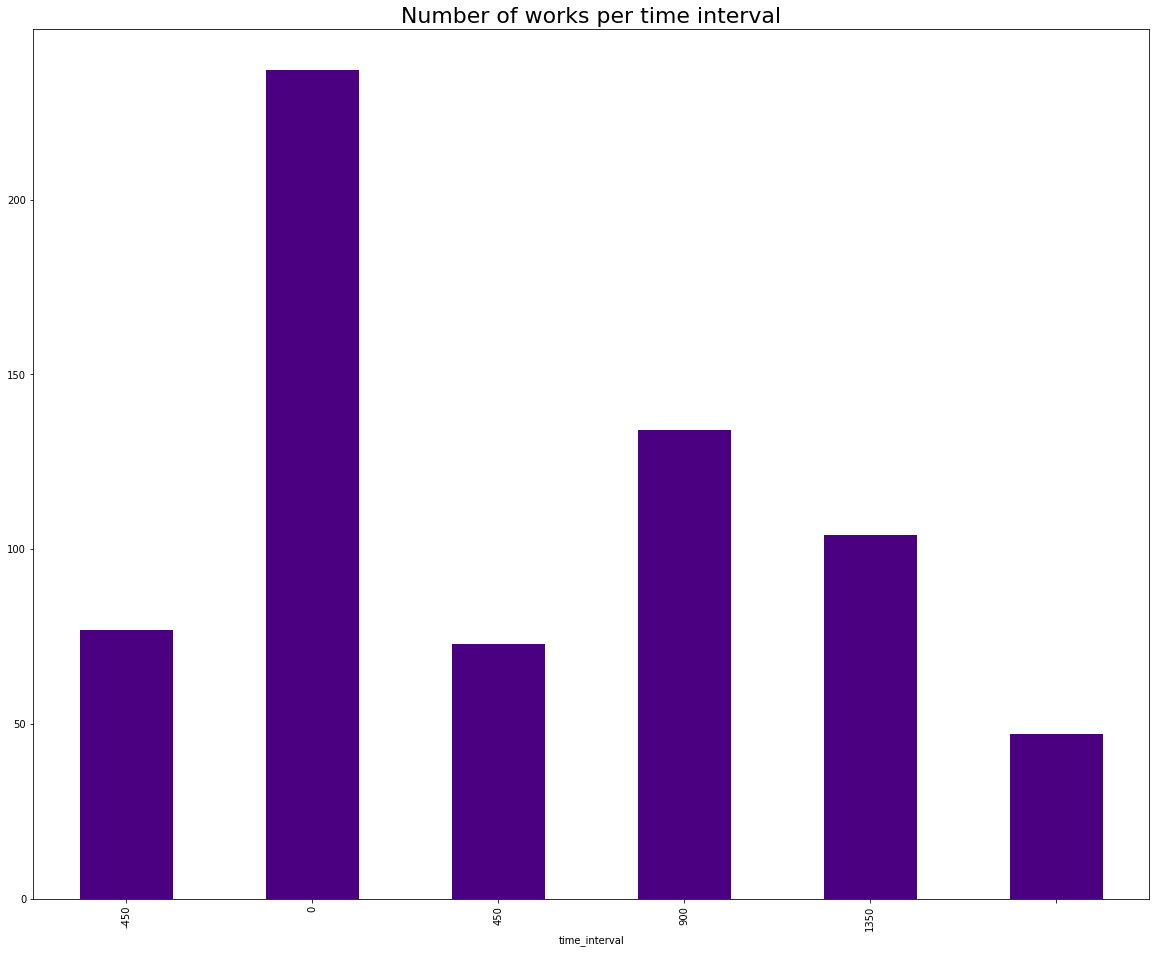

In [35]:
metadata_df0 = metadata_df.groupby(['time_interval']).count()
metadata_df0 = metadata_df0['id']
metadata_df0
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per time interval", fontsize=22)
plt.show()

## Training embeddings for the whole corpus

Function for printing the vocabulary of a model

In [ ]:
def print_vocab(model, top_n = None):
  if model == '':
    print("Empty model!")
  else:
    count = 0
    if top_n is not None:
      for index, word in enumerate(model.wv.index_to_key):
        count+= 1
        if count < top_n:
          print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
    else:
      for index, word in enumerate(model.wv.index_to_key):
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

Function for training FastText models (from Krzysztof Nowak):

In [27]:
def fasttext(self, opts=dict()):
        """
        Reads sentences from the corpus. Implements:
            https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText
        Returns
        -------
        FastText model
        """
        default_opts = dict(vector_size=100, alpha=0.025,
                            window=5, min_count=5, epochs=5)
        opts_new = default_opts
        for opt in opts.keys():
            opts_new[opt] = opts[opt]
        model = FastText(
            vector_size=opts_new["vector_size"],
            alpha=opts_new["alpha"],
            window=opts_new["window"],
            min_count=opts_new["min_count"])
        model.build_vocab(corpus_iterable=[sentence for sentence in
                                           self.corpus.get_sents()])
        total_examples = model.corpus_count
        model.train(corpus_iterable=[sentence for sentence
                                     in self.corpus.get_sents()],
                    total_examples=total_examples,
                    epochs=opts_new["epochs"])
        return model

Parameters: 

`min_count`: the minimum frequency threshold allowed for a word to be included; set to 3 following Ribary & McGillivray (2020) or 5 following Sprugnoli et al. (2019).

`vector_size`: the number of dimensions in which we wish to represent our word. This is the size of the word embedding; typically between 100 and 1,000. Set to 100 following Ribary & McGillivray (2020).

`window`: The size of the context window determines how many words before and after a given word would be included as context words of the given word.  Typically between 5 and 10. Set to 10 following Sprugnoli et al. (2020).

`sg`: – Training algorithm: 1 for skip-gram; otherwise CBOW. Set to 10 following Ribary & McGillivray (2020).


Train FastText embeddings and, for full reproducibility, limit the model to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling:

In [28]:
model = FastText(vector_size=100, alpha=0.025, window=1, min_count=5, workers=1, seed=1, hashfxn=hash)
model.build_vocab(corpus_iterable=corpus_corrected)
model.train(corpus_iterable=corpus_corrected, total_examples=model.corpus_count, epochs=5)

KeyboardInterrupt: 

#### First test: Minimal frequency = 5 (check for lower frequency words) and vector size = 100

Let's see what words are similar to "revolutio":

In [100]:
model.wv.similar_by_word('revolutio', 10)

[('resolutio', 0.9540356993675232),
 ('deglutio', 0.91014164686203),
 ('ablutio', 0.9017621278762817),
 ('remotio', 0.9016410708427429),
 ('relaxatio', 0.8993710279464722),
 ('redargutio', 0.8993261456489563),
 ('dissolutio', 0.8978363275527954),
 ('revocatio', 0.8933592438697815),
 ('redhibitio', 0.8921733498573303),
 ('reductio', 0.8900423645973206)]

#### Test 2: Adding max_n=0 and min_n=0 to avoid selection at the string level (turn off subwords), keep the other parameters steady

In [101]:
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1, hashfxn=hash, max_n = 0, min_n = 0)
model.build_vocab(corpus_iterable=corpus_corrected)
model.train(corpus_iterable=corpus_corrected, total_examples=model.corpus_count, epochs=5)

(35747461, 44714280)

In [102]:
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('revolutio', 10)

It has taken 135 seconds


[('vergiliarum', 0.7996066212654114),
 ('solstitialis', 0.7992427945137024),
 ('autumnale', 0.7899214625358582),
 ('solstitium', 0.779084324836731),
 ('arcticum', 0.7735402584075928),
 ('tricesima', 0.7699752449989319),
 ('semicirculus', 0.7656456232070923),
 ('cente(n)simus', 0.7655325531959534),
 ('sexdecim', 0.7599973082542419),
 ('octobri', 0.7569769024848938)]

ended here for now

## TO DO: add experiment min_count = 1 and subwords turned off

I experiment with two equivalent ways to train a Fast Text model:

In [41]:
model = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.corpus_count
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

(33210810, 44714280)

In [103]:
model2 = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash, 
                  sentences=corpus)
model2.corpus_count

523039

In [ ]:
np.allclose(model.wv['dies'], model2.wv['dies'])

The models has a vocabulary of

In [ ]:
model.corpus_total_words

words and 

In [ ]:
model.corpus_count

sentences.

I evaluate different configurations of the parameters for the embeddings against the gold standard set by Sprugnoli et al. (2019) (https://github.com/CIRCSE/Lemma-Embeddings-for-Latin/blob/master/syn-selection-benchmark-Latin.tsv) to find the best configuration of parameters:

https://gitlab.surrey.ac.uk/mr0048/pydigest/-/blob/master/script/fasttext_003.py

WE MAY ALSO WANT TO EVALUATE THE TIME-INSENSITIVE EMBEDDINGS (i.e. trained of the full corpus) similarly to Ribary & McGillivray (2020)

Split the corpus into subcorpora

Let's inspect the corpus for the first time interval:

In [29]:
subcorpus2corpus[0]

[['frater', 'quis#2', 'sum', 'per', 'Aegyptus', 'Iudaei', 'salus', 'dico#2'],
 ['frater',
  'quis#2',
  'sum',
  'in',
  'Hierosolyma',
  'Iudaei',
  'et',
  'quis#2',
  'in',
  'regio'],
 ['Iudaea', 'et', 'pax', 'bonus'],
 ['benefacio',
  'vos',
  'deus',
  'et',
  'memini',
  'testamentum',
  'suus',
  'quod',
  'sum'],
 ['ad', 'Abraham', 'et', 'Isaac', 'et', 'Iacob', 'servus', 'suus', 'fidelis'],
 ['et', 'do', 'vos', 'cor', 'omnis', 'ut', 'colo', 'is', 'et', 'facio', 'is'],
 ['voluntas', 'cor', 'magnus', 'et', 'animus', 'volente'],
 ['adaperio',
  'cor',
  'vos',
  'in',
  'lex',
  'suus',
  'et',
  'in',
  'praeceptum',
  'is',
  'et'],
 ['facio', 'pax'],
 ['exaudio', 'oratio', 'vester', 'et', 'reconcilio', 'vos', 'nec', 'vos'],
 ['desero', 'in', 'tempus', 'malus'],
 ['et', 'nunc', 'hic', 'sum', 'oro', 'pro', 'vos'],
 ['regno',
  'Demetrium',
  'annus',
  'centesimus',
  'sexagesimus',
  'nonus',
  'nos',
  'Iudaei'],
 ['scribo',
  'vos',
  'in',
  'tribulatio',
  'et',
  'impetus'

And the second:

In [30]:
subcorpus2corpus[1]

[['ut',
  'alimentum',
  'sanus',
  'corpus',
  'agricultura',
  'sic',
  'sanitas',
  'aegrum',
  'medicinus',
  'promitto'],
 ['hic',
  'nusquam',
  'quidem',
  'non',
  'sum',
  'siquidem',
  'etiam',
  'inperitissimae',
  'gens',
  'herba',
  'aliaque',
  'promta',
  'in',
  'auxilium',
  'vulnus',
  'morborumque',
  'nosco'],
 ['verus',
  'tamen',
  'apud',
  'Graecus',
  'aliquantus',
  'magis',
  'quam#4',
  'in',
  'ceterus',
  'natio',
  'excolo',
  'sum',
  'atque',
  'ne#2',
  'apud',
  'hic',
  'quidem',
  'ab',
  'primus',
  'origo',
  'sed',
  'paucus',
  'ante',
  'nos',
  'saeculum'],
 ['ut',
  'pote',
  'cum',
  'vetustus',
  'auctor',
  'Aesculapius',
  'celebro',
  'quis#2',
  'quoniam',
  'adhuc',
  'rudis',
  'et',
  'vulgaris',
  'hic',
  'scientia',
  'paulum',
  'subtilis',
  'excoluit',
  'in',
  'deus',
  'numerus',
  'recipio',
  'sum'],
 ['hic',
  'deinde',
  'duo',
  'filius',
  'Podalirius',
  'et',
  'Machaon',
  'bellum',
  'Troiano',
  'dux',
  'Agamemn

Following the findings of Sprugnoli et al. (2019) and Ribary & McGillivray (2020), for each subcorpus I train a fasttext model:

Start with the first subcorpus:
Barbara: "The corpus is small and the fasttext seems to prefer orthographic similarity with smaller min_counts. We're not interested in dies being similar to rabies, but rather dies being similar to annus or mensis. So, we have two options: we may either turn off the subwords or apply high frequency threshold (but we're going to loose low-frequency terms)"

Try excluding subwords and setting minimal frequency to 5 (see experiment on embeddings for the full corpus with "causa": ideal combination of parameters is max_n=0, min_n=0, min_count=5

In [31]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1, hashfxn=hash, min_n=0, max_n=0)
model.build_vocab(corpus_iterable=subcorpus2corpus[0])
model.train(corpus_iterable=subcorpus2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('causa', 10)

KeyboardInterrupt: 

In [37]:
print_vocab(model, 10)

word #0/33583 is et
word #1/33583 is sum
word #2/33583 is in
word #3/33583 is quis#2
word #4/33583 is is
word #5/33583 is non
word #6/33583 is hic
word #7/33583 is ad
word #8/33583 is ut


Another test with "sum"

In [38]:
model.wv.similar_by_word('sum', 10)

[('appareo', 0.5292460918426514),
 ('habeo', 0.517448902130127),
 ('existo', 0.5027661919593811),
 ('invenio', 0.48599913716316223),
 ('permaneo', 0.4838952422142029),
 ('iudico', 0.48345261812210083),
 ('indigeo', 0.48066267371177673),
 ('contingo', 0.4800867736339569),
 ('praecedo', 0.467045396566391),
 ('nasco', 0.46400588750839233)]

Additionally, we could set a higher frequency threshold, but that we would lose low-frequency terms: with minimal frequency = 50

In [166]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=50, workers=1, seed=1, hashfxn=hash, max_n=0) 
model.build_vocab(corpus_iterable=subcorpus2corpus[0])
model.train(corpus_iterable=subcorpus2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('causa', 10)

It has taken 66 seconds


[('lite', 0.6106802225112915),
 ('accusatio', 0.6002997159957886),
 ('disceptatio', 0.5790320038795471),
 ('ratio', 0.5747724771499634),
 ('defensio', 0.5611129403114319),
 ('deliberatio', 0.5604794025421143),
 ('probatio', 0.5601478815078735),
 ('quaestio', 0.5547122955322266),
 ('culpa', 0.5457818508148193),
 ('crimen', 0.5342454314231873)]

### Train one model for each subcorpus
I now train one model for each subcorpus (medical vs. non medical): set minimal frequency 5 and exclude subwords

In [32]:
len(subcorpus2corpus)

2

In [33]:
models = list()
start = time.time()
for s in range(len(subcorpus2corpus)):
    if len(subcorpus2corpus[s])>0:
        print(s)
        #model = gensim.models.Word2Vec(time2corpus[0][0], min_count=1, vector_size=300, window = 5, sg = 0)
        model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1, hashfxn=hash, max_n=0, min_n=0)  # instantiate
        model.build_vocab(corpus_iterable=subcorpus2corpus[s])
        model.train(corpus_iterable=subcorpus2corpus[s], total_examples=len(subcorpus2corpus[s]), epochs=10)  # train
        models.append(model)
        #model = fasttext.train_unsupervised(time2corpus[0][0], model='skipgram')
end = time.time()
print("It has taken", round(end - start), "seconds, or ", round((end - start)/60), "minutes")

0
1
It has taken 198 seconds, or  3 minutes


Check on the two models

In [41]:
print_vocab(models[0], 20)

word #0/33583 is et
word #1/33583 is sum
word #2/33583 is in
word #3/33583 is quis#2
word #4/33583 is is
word #5/33583 is non
word #6/33583 is hic
word #7/33583 is ad
word #8/33583 is ut
word #9/33583 is ab
word #10/33583 is cum
word #11/33583 is ille
word #12/33583 is omnis
word #13/33583 is dico#2
word #14/33583 is quod
word #15/33583 is suus
word #16/33583 is de
word #17/33583 is si
word #18/33583 is ego


## Check malus

In [42]:
models[0].wv.similar_by_word('malus', 10)

[('malus#3', 0.7445393800735474),
 ('deterior', 0.6224241256713867),
 ('publicatio', 0.550349771976471),
 ('conscientia', 0.5132147073745728),
 ('fraudis', 0.503659725189209),
 ('invidus', 0.5022456645965576),
 ('malignitas', 0.48834073543548584),
 ('nequitia', 0.48028719425201416),
 ('malitia', 0.47844555974006653),
 ('pessimi', 0.4778210520744324)]

In [43]:
print_vocab(models[1], 20)

word #0/2122 is sum
word #1/2122 is et
word #2/2122 is is
word #3/2122 is in
word #4/2122 is quis#2
word #5/2122 is si
word #6/2122 is ex
word #7/2122 is hic
word #8/2122 is vel
word #9/2122 is non
word #10/2122 is aut
word #11/2122 is quod
word #12/2122 is ut
word #13/2122 is cum
word #14/2122 is ad
word #15/2122 is ab
word #16/2122 is quoque
word #17/2122 is sed
word #18/2122 is etiam


In [44]:
models[1].wv.similar_by_word('malus', 10)

[('difficultas', 0.9630550742149353),
 ('articulus', 0.9567130208015442),
 ('consuesco', 0.9554041624069214),
 ('male', 0.9552204012870789),
 ('urina', 0.9537398219108582),
 ('voluntas', 0.9534554481506348),
 ('spes', 0.9531292915344238),
 ('sensus', 0.9526328444480896),
 ('insania', 0.9525879621505737),
 ('vesica', 0.9525068998336792)]

## Check potio

In [45]:
models[0].wv.similar_by_word('potio', 10)

[('potus', 0.596651554107666),
 ('sopio', 0.5308095216751099),
 ('quies', 0.5303115844726562),
 ('medicamentum', 0.5270382165908813),
 ('cibus', 0.5206639766693115),
 ('satio', 0.515001654624939),
 ('potionis', 0.5114859342575073),
 ('somnoque', 0.5112212896347046),
 ('haurio', 0.5046415328979492),
 ('adlici', 0.4984215795993805)]

In [46]:
models[1].wv.similar_by_word('potio', 10)

[('utor', 0.9829772114753723),
 ('abstineo', 0.9741743803024292),
 ('pridie', 0.9734511971473694),
 ('uti', 0.9712179899215698),
 ('egelidus', 0.9695520401000977),
 ('adsumo', 0.9688200354576111),
 ('acer', 0.9610457420349121),
 ('sumo', 0.9605630040168762),
 ('modicus', 0.9598569869995117),
 ('debeo', 0.9592777490615845)]

## Check lenticula

In [47]:
models[0].wv.similar_by_word('lenticula', 10)

[('perunges', 0.8608763813972473),
 ('asperso', 0.8605087995529175),
 ('cyperum', 0.8578701019287109),
 ('defritum', 0.8502394556999207),
 ('porrus', 0.8457130789756775),
 ('anethum', 0.8446499109268188),
 ('puleium', 0.8427358269691467),
 ('asperges', 0.841949999332428),
 ('silfi', 0.8419413566589355),
 ('pisum', 0.8400180339813232)]

In [48]:
models[1].wv.similar_by_word('lenticula', 10)

[('lac', 0.9950354695320129),
 ('ruta', 0.9947835803031921),
 ('olea', 0.99403315782547),
 ('marrubium', 0.9940274357795715),
 ('rubus', 0.9916974902153015),
 ('adjicio', 0.9916856288909912),
 ('sucidus', 0.9906005263328552),
 ('malicorium', 0.9898480772972107),
 ('farina', 0.9896025061607361),
 ('furfur', 0.9895826578140259)]

## Check Impetus

In [50]:
models[0].wv.similar_by_word('impetus', 10)

[('eruptio', 0.718285858631134),
 ('incursus', 0.6353676319122314),
 ('concursus', 0.6190795302391052),
 ('acriter', 0.5763891339302063),
 ('concito', 0.5652066469192505),
 ('uiribus', 0.560851514339447),
 ('pavor', 0.5604428648948669),
 ('perrumpo', 0.559894323348999),
 ('inpetu', 0.5539030432701111),
 ('rabies', 0.5501555800437927)]

In [51]:
models[1].wv.similar_by_word('impetus', 10)

[('scroto', 0.997705340385437),
 ('iacio', 0.9975391626358032),
 ('inbecillitas', 0.9973631501197815),
 ('mature', 0.9973325133323669),
 ('mano', 0.9972262382507324),
 ('numquam', 0.9970070719718933),
 ('aliquando', 0.9968353509902954),
 ('vaco', 0.996812105178833),
 ('muto', 0.9967483878135681),
 ('totus', 0.9967460632324219)]

## Check Plaga

In [52]:
models[0].wv.similar_by_word('plaga', 10)

[('contritio', 0.49932730197906494),
 ('septentrionalis', 0.47354528307914734),
 ('aquilo', 0.4706868827342987),
 ('pessima', 0.4643608033657074),
 ('septentrionem', 0.4558558166027069),
 ('meridies', 0.4414684474468231),
 ('desolo', 0.43876615166664124),
 ('serpens', 0.43028056621551514),
 ('languor', 0.43025338649749756),
 ('sibilo', 0.4296463131904602)]

In [53]:
models[1].wv.similar_by_word('plaga', 10)

[('crus', 0.9959562420845032),
 ('ibi', 0.994205892086029),
 ('scalpellum', 0.9938284158706665),
 ('extendo', 0.9937617182731628),
 ('descendo', 0.9934535622596741),
 ('excidium', 0.993284285068512),
 ('ergo', 0.9932499527931213),
 ('proximus', 0.9931142330169678),
 ('integer', 0.9930745363235474),
 ('iacio', 0.9929271936416626)]

## Check anus

In [54]:
models[0].wv.similar_by_word('anus', 10)

[('formosus', 0.7208097577095032),
 ('nutrico', 0.7165568470954895),
 ('delicatus', 0.6415420770645142),
 ('mamma', 0.6402621269226074),
 ('virguncula', 0.6257895827293396),
 ('nutrix', 0.6114704012870789),
 ('Sabina', 0.6049647331237793),
 ('lacto', 0.5958934426307678),
 ('puella', 0.5957138538360596),
 ('thalamus', 0.5906150341033936)]

In [55]:
models[1].wv.similar_by_word('anus', 10)

[('maxilla', 0.9982499480247498),
 ('inguen', 0.9979749917984009),
 ('iuxta', 0.9974749088287354),
 ('ferramentum', 0.9971880912780762),
 ('scrotum', 0.9971383213996887),
 ('antequam', 0.9969991445541382),
 ('vinculum', 0.9969804883003235),
 ('glutino', 0.9967426061630249),
 ('sedeo', 0.9965815544128418),
 ('vulnero', 0.9965251684188843)]

## Check Aranea

In [56]:
models[0].wv.similar_by_word('aranea', 10)

[('pharetra', 0.6134344339370728),
 ('vibro', 0.6050527095794678),
 ('transfigo', 0.6030136346817017),
 ('sulpur', 0.5997458696365356),
 ('hastile', 0.5971342325210571),
 ('texentium', 0.5743292570114136),
 ('stipula', 0.5697602033615112),
 ('ferrum', 0.5689342617988586),
 ('liciatorium', 0.5648847818374634),
 ('spiculus', 0.5626999139785767)]

In [57]:
models[1].wv.similar_by_word('aranea', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Check Cancer

In [58]:
models[0].wv.similar_by_word('cancer', 10)

[('aequinoctialis', 0.7350070476531982),
 ('Capricornus', 0.7211254239082336),
 ('lune', 0.7174912691116333),
 ('Chelis', 0.7116904854774475),
 ('exortus', 0.7026336193084717),
 ('Orion', 0.6997062563896179),
 ('Hydrae', 0.696772038936615),
 ('Cancri', 0.6959371566772461),
 ('brumalis', 0.676031231880188),
 ('exoriri', 0.6754188537597656)]

In [59]:
models[1].wv.similar_by_word('cancer', 10)

[('perniciosus', 0.9970979690551758),
 ('muto', 0.9970343112945557),
 ('abscido', 0.9969481825828552),
 ('animal', 0.9968684315681458),
 ('vetustas', 0.9966973066329956),
 ('afficio', 0.9966148734092712),
 ('occupo', 0.9965019226074219),
 ('desum', 0.9964045882225037),
 ('vinculum', 0.9962295889854431),
 ('caelum', 0.9959255456924438)]

## Check Caninus

In [36]:
models[0].wv.similar_by_word('caninus', 10)

[('palo', 0.7080064415931702),
 ('palustrem', 0.7017350196838379),
 ('unctus', 0.6942863464355469),
 ('sucidus', 0.6911542415618896),
 ('pampinus', 0.6911504864692688),
 ('myrteum', 0.6873365044593811),
 ('caedito', 0.686789333820343),
 ('refoveo', 0.686775803565979),
 ('Arsa', 0.6860144138336182),
 ('balsamum', 0.6847855448722839)]

In [37]:
models[1].wv.similar_by_word('caninus', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Colis

In [40]:
models[0].wv.similar_by_word('caulis', 10)

[('baiulum', 0.0),
 ('vicissimque', 0.0),
 ('auferendo', 0.0),
 ('turbavere', 0.0),
 ('deprecarentur', 0.0),
 ('Parmenion', 0.0),
 ('potentum', 0.0),
 ('destructor', 0.0),
 ('osteum', 0.0),
 ('Clausus', 0.0)]

In [41]:
models[1].wv.similar_by_word('caulis', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Fistula

In [42]:
models[0].wv.similar_by_word('fistula', 10)

[('vicenum', 0.7571058869361877),
 ('centenum', 0.727862536907196),
 ('modulus', 0.7275359630584717),
 ('diametrum', 0.7077943682670593),
 ('plumbea', 0.7031548023223877),
 ('vicenarius', 0.6905785799026489),
 ('semuncia', 0.6882086992263794),
 ('pertundito', 0.6747350692749023),
 ('crocus', 0.6727489829063416),
 ('quadratus', 0.6727017164230347)]

In [43]:
models[1].wv.similar_by_word('fistula', 10)

[('abscido', 0.9949777722358704),
 ('patefacio', 0.9944912195205688),
 ('membrana', 0.994250476360321),
 ('vinculum', 0.9940910935401917),
 ('cancer', 0.9940453171730042),
 ('rumpo', 0.9939383268356323),
 ('naturalis', 0.9937660694122314),
 ('quicumque', 0.9937065243721008),
 ('talus', 0.9936233758926392),
 ('ala', 0.9935315847396851)]

## Folliculus

In [44]:
models[0].wv.similar_by_word('folliculus', 10)

[('pampinus', 0.8198416829109192),
 ('pineum', 0.8055068850517273),
 ('furfur', 0.8008548617362976),
 ('citrum', 0.796357274055481),
 ('callosus', 0.7912360429763794),
 ('lupinus', 0.7903788089752197),
 ('ficos', 0.787680983543396),
 ('sucidus', 0.7866107821464539),
 ('ulmeus', 0.7819167375564575),
 ('damascena', 0.78098064661026)]

In [45]:
models[1].wv.similar_by_word('folliculus', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Lumen

In [46]:
models[0].wv.similar_by_word('lumen', 10)

[('fulgor', 0.7066628932952881),
 ('lux', 0.6773566603660583),
 ('lucidus', 0.6475052237510681),
 ('radius', 0.6295573115348816),
 ('candor', 0.6255735754966736),
 ('caligo', 0.6172627210617065),
 ('luceo', 0.592840313911438),
 ('inlumino', 0.5927273035049438),
 ('splendor', 0.5899431109428406),
 ('caliginem', 0.5879647135734558)]

In [47]:
models[1].wv.similar_by_word('lumen', 10)

[('expeditus', 0.9964432120323181),
 ('plerumque', 0.9961612224578857),
 ('paene', 0.9961373805999756),
 ('restituo', 0.9958831667900085),
 ('curiosus', 0.9958614706993103),
 ('infans', 0.9958545565605164),
 ('capillus', 0.9958263635635376),
 ('adversus', 0.9957664012908936),
 ('prolabor', 0.9956214427947998),
 ('planta', 0.995497465133667)]

## Menstrua

In [49]:
models[0].wv.similar_by_word('menstruus', 10)

[('quintadecima', 0.6784973740577698),
 ('coagulo', 0.6650052070617676),
 ('effluxerit', 0.6644333600997925),
 ('caedito', 0.6587182283401489),
 ('Octobrium', 0.6507802605628967),
 ('seruentur', 0.6498989462852478),
 ('putrescit', 0.6493684649467468),
 ('decembri', 0.6474031805992126),
 ('autumnalis', 0.6436105966567993),
 ('uespera', 0.6390299797058105)]

In [51]:
models[1].wv.similar_by_word('menstruus', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Mola

In [52]:
models[0].wv.similar_by_word('mola', 10)

[('plumbum', 0.746660053730011),
 ('aggero', 0.7344804406166077),
 ('cratis', 0.7252821922302246),
 ('bitumen', 0.703269362449646),
 ('crates', 0.7016198635101318),
 ('asinarius', 0.7005409002304077),
 ('funis', 0.6971569061279297),
 ('lamminis', 0.6944992542266846),
 ('condensus', 0.6931260228157043),
 ('coagmento', 0.6929770112037659)]

In [53]:
models[1].wv.similar_by_word('mola', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Musculus

In [54]:
models[0].wv.similar_by_word('musculus', 10)

[('cratis', 0.8192490935325623),
 ('pluteum', 0.7833704352378845),
 ('tabulatus', 0.7824996113777161),
 ('ballista', 0.7676939368247986),
 ('vimen', 0.7657342553138733),
 ('trabes', 0.7561563849449158),
 ('stipites', 0.7425310015678406),
 ('sudibus', 0.7417828440666199),
 ('tignum', 0.7387229800224304),
 ('corium', 0.7376952171325684)]

In [55]:
models[1].wv.similar_by_word('musculus', 10)

[('rumpo', 0.9939658641815186),
 ('incisum', 0.9939491152763367),
 ('exeo', 0.9936187267303467),
 ('subsum', 0.9931867122650146),
 ('decido', 0.993084192276001),
 ('mors', 0.992587685585022),
 ('vitio', 0.9925201535224915),
 ('cucurbitula', 0.9923760294914246),
 ('appareo', 0.9922506809234619),
 ('tumeo', 0.9920444488525391)]

## Patella

In [56]:
models[0].wv.similar_by_word('patella', 10)

[('patina', 0.8819414973258972),
 ('caccabus', 0.8786182999610901),
 ('oenogaro', 0.8742801547050476),
 ('mortarium', 0.8705757260322571),
 ('frico', 0.8621558547019958),
 ('cocta', 0.8574983477592468),
 ('perunges', 0.8552541732788086),
 ('liquamine', 0.8513573408126831),
 ('surclas', 0.8509286642074585),
 ('furnus', 0.8497797250747681)]

In [57]:
models[1].wv.similar_by_word('patella', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Pecten

In [58]:
models[0].wv.similar_by_word('pecten', 10)

[('baiulum', 0.0),
 ('vicissimque', 0.0),
 ('auferendo', 0.0),
 ('turbavere', 0.0),
 ('deprecarentur', 0.0),
 ('Parmenion', 0.0),
 ('potentum', 0.0),
 ('destructor', 0.0),
 ('osteum', 0.0),
 ('Clausus', 0.0)]

## Pupilla

In [59]:
models[0].wv.similar_by_word('pupilla', 10)

[('pupillus', 0.6586187481880188),
 ('tutor', 0.6093322038650513),
 ('administrasse', 0.6037088632583618),
 ('tutela', 0.5639089941978455),
 ('obligatus', 0.5460118651390076),
 ('curator', 0.5336513519287109),
 ('patrona', 0.5176621675491333),
 ('vidua', 0.5000547766685486),
 ('pupillaris', 0.4934292137622833),
 ('pignus', 0.48506319522857666)]

In [60]:
models[1].wv.similar_by_word('pupilla', 10)

[('commode', 0.9960851073265076),
 ('protraho', 0.995667040348053),
 ('exaspero', 0.995612621307373),
 ('coicienda', 0.9955204129219055),
 ('specillo', 0.9954385161399841),
 ('inde', 0.995216429233551),
 ('labrum', 0.9949774146080017),
 ('mamma', 0.9946674108505249),
 ('conpremo', 0.9946157932281494),
 ('testa', 0.994404137134552)]

## Scrotum

In [64]:
models[0].wv.similar_by_word('scrautum', 10)

[('baiulum', 0.0),
 ('vicissimque', 0.0),
 ('auferendo', 0.0),
 ('turbavere', 0.0),
 ('deprecarentur', 0.0),
 ('Parmenion', 0.0),
 ('potentum', 0.0),
 ('destructor', 0.0),
 ('osteum', 0.0),
 ('Clausus', 0.0)]

## Spina

In [67]:
models[0].wv.similar_by_word('spina', 10)

[('folium', 0.7782173752784729),
 ('vepres', 0.7522402405738831),
 ('stramentum', 0.738955020904541),
 ('locusta', 0.7326549291610718),
 ('oliva', 0.7314444184303284),
 ('testa', 0.7297854423522949),
 ('arista', 0.721219003200531),
 ('spica', 0.7201421856880188),
 ('granum', 0.719623863697052),
 ('virgultum', 0.7191399931907654)]

In [66]:
models[1].wv.similar_by_word('spina', 10)

[('vertebra', 0.9980313777923584),
 ('retundo', 0.9976984858512878),
 ('uncus', 0.9976956248283386),
 ('sinuo', 0.997674822807312),
 ('apprehendo', 0.9971036911010742),
 ('cerebrum', 0.9969908595085144),
 ('inhaeresco', 0.9969809055328369),
 ('costa', 0.9968867301940918),
 ('rima', 0.9968589544296265),
 ('transversum', 0.9968309998512268)]

## Spiritus

In [68]:
models[0].wv.similar_by_word('spiritus', 10)

[('trinitas', 0.5778629779815674),
 ('angelus', 0.5743215680122375),
 ('Trinitatis', 0.5146111845970154),
 ('diabolus', 0.5006036758422852),
 ('invocatio', 0.4707029163837433),
 ('inspiratio', 0.46047791838645935),
 ('corruptio', 0.4583539068698883),
 ('caro', 0.45777449011802673),
 ('angelicus', 0.45664042234420776),
 ('anima', 0.44951263070106506)]

In [69]:
models[1].wv.similar_by_word('spiritus', 10)

[('nam', 0.9927971959114075),
 ('intus', 0.9913724064826965),
 ('pus', 0.9886324405670166),
 ('frango', 0.9884505271911621),
 ('tumor', 0.9881983995437622),
 ('relinquo', 0.988068163394928),
 ('motus', 0.9880082011222839),
 ('febre', 0.9873912930488586),
 ('nonnumquam', 0.9869715571403503),
 ('intendo', 0.9869352579116821)]

## Tibia

In [70]:
models[0].wv.similar_by_word('tibia', 10)

[('fides#2', 0.7541792988777161),
 ('cantus', 0.7499963641166687),
 ('cymbalum', 0.7445164918899536),
 ('lyra', 0.7413572072982788),
 ('cithara', 0.7400211095809937),
 ('tympanum', 0.7399448752403259),
 ('tinnitus', 0.7395069003105164),
 ('organum', 0.7257954478263855),
 ('plectrum', 0.7043542861938477),
 ('chorda', 0.6989166736602783)]

In [71]:
models[1].wv.similar_by_word('tibia', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Vitium

In [72]:
models[0].wv.similar_by_word('vitium', 10)

[('avaritia', 0.6334289312362671),
 ('uitiis', 0.62870192527771),
 ('inertia', 0.6192713379859924),
 ('vitiosus', 0.6179677248001099),
 ('culpa', 0.6062299609184265),
 ('stultitia', 0.6019758582115173),
 ('malitia', 0.5940094590187073),
 ('insolentia', 0.5920464992523193),
 ('neglegentia', 0.5816465616226196),
 ('nequitia', 0.5792486667633057)]

In [73]:
models[1].wv.similar_by_word('vitium', 10)

[('video', 0.9915851354598999),
 ('ferus', 0.9847535490989685),
 ('medicina', 0.9810498952865601),
 ('casus', 0.9806272387504578),
 ('sub', 0.9806148409843445),
 ('autem', 0.9795443415641785),
 ('incido#2', 0.978618860244751),
 ('auxilium', 0.9781866073608398),
 ('orior', 0.9775609374046326),
 ('causa', 0.9765673875808716)]

## Salus

In [34]:
models[0].wv.similar_by_word('salus', 10)

[('incolumitas', 0.7022579312324524),
 ('conservo', 0.5443711280822754),
 ('clementia', 0.4989524483680725),
 ('periculum', 0.4911067485809326),
 ('supplico', 0.48557671904563904),
 ('innocentia', 0.4801259934902191),
 ('redemptio', 0.47199010848999023),
 ('beneficus', 0.47106367349624634),
 ('obsecratio', 0.46735039353370667),
 ('ultio', 0.4653434753417969)]

In [35]:
models[1].wv.similar_by_word('salus', 10)

[('tenebrae', 0.9944223761558533),
 ('insanio', 0.994313657283783),
 ('momentum', 0.9940486550331116),
 ('num', 0.9936050772666931),
 ('simplex', 0.9935969114303589),
 ('ordo', 0.9935298562049866),
 ('varietas', 0.9934267401695251),
 ('sapientia', 0.9933403134346008),
 ('expeditus', 0.9933046102523804),
 ('penitus#3', 0.9931431412696838)]